In [1]:
! chmod 600 /content/kaggle.json

! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d grouplens/movielens-20m-dataset

 94% 184M/195M [00:00<00:00, 249MB/s]
100% 195M/195M [00:00<00:00, 231MB/s]


## Data Preparation

In [2]:
import zipfile
zip_file = zipfile.ZipFile('/content/movielens-20m-dataset.zip')
zip_file.extractall('/tmp/')

### Import all realated libraries

In [4]:
# import libraries for data analysis
import numpy as np
import pandas as pd
import random
import os

# import library for visualization
import seaborn as sns
import matplotlib.pyplot as plt



### Import Dataset

In [5]:
rating=pd.read_csv('/tmp/rating.csv')
movies=pd.read_csv('/tmp/movie.csv')

print('Jumlah data rating oleh user: ', rating.shape[0])
print('Jumlah data informasi film: ', len(movies.movieId.unique()))

Jumlah data kumpulan tag film oleh user:  465564
Jumlah data rating oleh user:  20000263
Jumlah data informasi film:  27278
Jumlah data relevansi tag film:  11709768
Jumlah data informasi link film:  27278
Jumlah data deskripsi tag:  1128


# EDA

In [6]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [7]:
rating['timestamp'] = pd.to_datetime(rating['timestamp'])
rating.sort_values(by='timestamp', ascending=False)

,userId,movieId,rating,timestamp
12675921,87586,7151,3.5,2015-03-31 06:40:02
12898527,89081,52458,4.0,2015-03-31 06:11:28
12898546,89081,55232,3.5,2015-03-31 06:11:26
2508834,16978,2093,3.5,2015-03-31 06:03:17
7819902,53930,118706,3.5,2015-03-31 06:00:51
...,...,...,...,...
19424626,134445,45,5.0,1996-01-29 00:00:00
18950979,131160,1079,3.0,1995-01-09 11:46:49
18950936,131160,47,5.0,1995-01-09 11:46:49
18950930,131160,21,3.0,1995-01-09 11:46:49


### Cek Unique setiap kolom rating

In [8]:
for col in rating.columns:
    c = rating[col].nunique()
    print(f"Unique count of {col} is {c}")

Unique count of userId is 138493
Unique count of movieId is 26744
Unique count of rating is 10
Unique count of timestamp is 15351121


In [9]:
rating.drop(columns=['timestamp'],inplace=True)

In [10]:
rating.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [18]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [19]:
for col in movies.columns:
    c = movies[col].nunique()
    print(f"Unique count of {col} is {c}")

Unique count of movieId is 27278
Unique count of title is 27262
Unique count of genres is 1342


In [20]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [21]:
movies.shape

(27278, 3)

In [22]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


## Data Processing

### Menentukan user yang melakukan lebih dari 2000 kali memberikan rating (Downsampling)

In [32]:
x=rating['userId'].value_counts() > 2000
y = x[x].index
y.shape

(255,)

In [33]:
rating=rating[rating['userId'].isin(y)]
rating.shape

(694595, 3)

### Dataframe Rating merge dengan Dataframe movie_details

In [34]:
movie_details=movies.merge(rating,on='movieId')

In [35]:
movie_details.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,156,5.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,741,5.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,903,4.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,982,3.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2261,3.0


In [36]:
movie_details.shape

(694595, 5)

### Mencari rank dari rating

In [37]:
number_rating = movie_details.groupby('title')['rating'].count().reset_index()

In [38]:
number_rating.rename(columns={'rating':'rank of rating'},inplace=True)

In [39]:
number_rating.head()

,title,rank of rating
0,#chicagoGirl: The Social Network Takes on a Di...,2
1,$ (Dollars) (1971),5
2,$5 a Day (2008),5
3,$9.99 (2008),4
4,$ellebrity (Sellebrity) (2012),1


In [40]:
df=movie_details.merge(number_rating,on='title')

In [41]:
df.shape

(694595, 6)

In [42]:
df.sort_values(by='rank of rating', ascending=True)

,movieId,title,genres,userId,rating,rank of rating
694594,131180,Dead Rising: Watchtower (2015),Action|Horror|Thriller,117144,2.5,1
680772,100799,Living in Emergency: Stories of Doctors Withou...,Documentary,98865,4.0,1
680788,100843,Oh Boy (A Coffee in Berlin) (2012),Comedy|Drama,136268,3.0,1
680796,100904,Murder in Greenwich (2002),Crime|Drama|Mystery,59414,3.0,1
680803,100942,Gunfighter's Moon (1997),Romance|Western,73026,3.0,1
...,...,...,...,...,...,...
87222,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi,52636,4.0,254
87223,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi,53346,4.0,254
87224,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi,53640,4.0,254
87211,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi,46396,3.0,254


### Memilih rank rating >= 50

In [43]:
df=df[df['rank of rating']<=50] 

In [44]:
df.drop_duplicates(['title','userId'],inplace=True)

In [45]:
df.shape

(195127, 6)

In [46]:
df.head()

,movieId,title,genres,userId,rating,rank of rating
1180,8,Tom and Huck (1995),Adventure|Children,903,3.0,37
1181,8,Tom and Huck (1995),Adventure|Children,6719,1.0,37
1182,8,Tom and Huck (1995),Adventure|Children,10761,4.0,37
1183,8,Tom and Huck (1995),Adventure|Children,14705,1.0,37
1184,8,Tom and Huck (1995),Adventure|Children,18611,1.0,37


In [47]:
df.drop(columns=['rank of rating'],inplace=True)

In [48]:
df.head()

,movieId,title,genres,userId,rating
1180,8,Tom and Huck (1995),Adventure|Children,903,3.0
1181,8,Tom and Huck (1995),Adventure|Children,6719,1.0
1182,8,Tom and Huck (1995),Adventure|Children,10761,4.0
1183,8,Tom and Huck (1995),Adventure|Children,14705,1.0
1184,8,Tom and Huck (1995),Adventure|Children,18611,1.0


In [49]:
movie_pivot=df.pivot_table(columns='userId',index='title',values='rating')

In [50]:
movie_pivot.shape

(17908, 255)

In [51]:
movie_pivot.fillna(0,inplace=True)

In [52]:
movie_pivot

userId,156,741,903,982,2261,3318,3907,4222,4358,6636,...,134773,135090,135425,136268,136599,137202,137277,137343,137686,138208
title,,,,,,,,,,,,,,,,,,,,,
#chicagoGirl: The Social Network Takes on a Dictator (2013),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$ (Dollars) (1971),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$5 a Day (2008),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$9.99 (2008),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$ellebrity (Sellebrity) (2012),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
À l'aventure (2008),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
À nos amours (1983),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
À nous la liberté (Freedom for Us) (1931),0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Membuat variabel preparation yang berisi dataframe movie kemudian mengurutkan berdasarkan movieId

In [53]:
preparation = df
preparation.sort_values('movieId')

,movieId,title,genres,userId,rating
1180,8,Tom and Huck (1995),Adventure|Children,903,3.0
1201,8,Tom and Huck (1995),Adventure|Children,83090,2.0
1202,8,Tom and Huck (1995),Adventure|Children,86839,4.0
1203,8,Tom and Huck (1995),Adventure|Children,88820,3.0
1204,8,Tom and Huck (1995),Adventure|Children,101861,1.0
...,...,...,...,...,...
694590,131017,Aziz Ansari: Live at Madison Square Garden (2015),Comedy,59477,2.5
694591,131019,The Intruders (2015),Thriller,39214,3.0
694592,131110,A House of Secrets: Exploring 'Dragonwyck' (2008),Documentary,131651,3.0
694593,131172,Closed Curtain (2013),(no genres listed),128309,1.0


<ipython-input-68-33d0c690bd3f>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = preparation.corr()


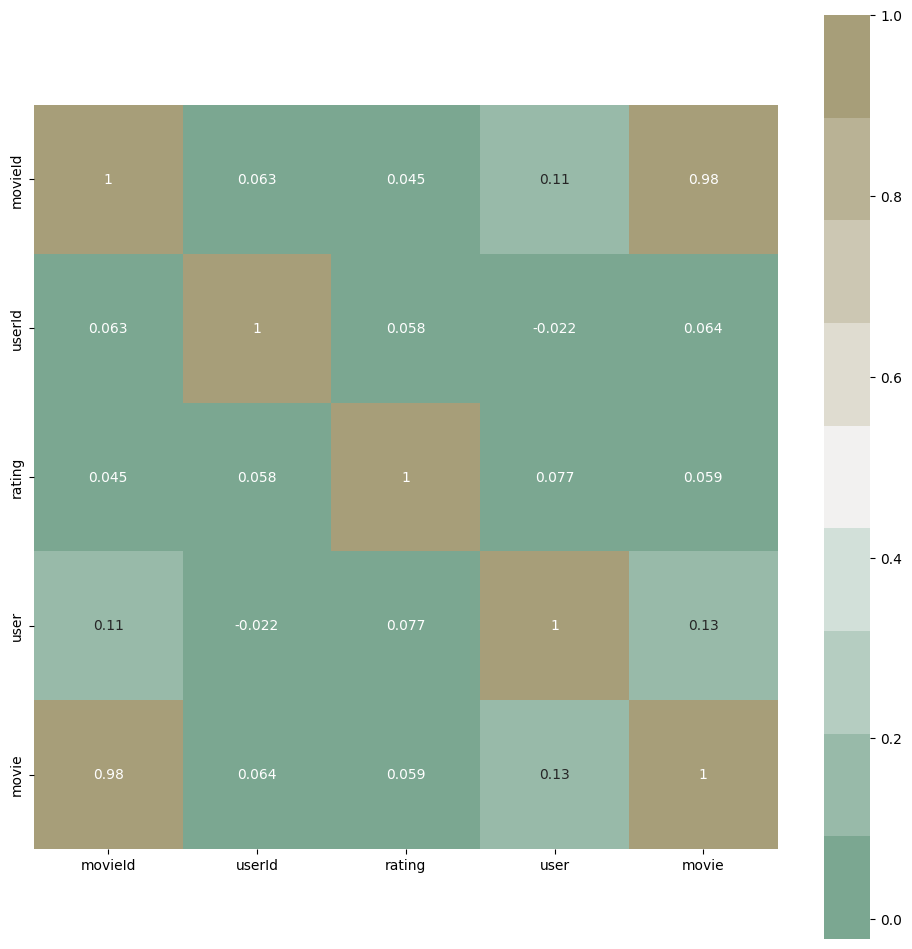

In [68]:
import seaborn as sns
cmap=sns.diverging_palette(150,75,  s=40, l=65, n=9)
corrmat = preparation.corr()
plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, square=True);

### Model Development (Encoding)

In [54]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = preparation['userId'].unique().tolist()
print('list userID: ', user_ids)
 
# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)
 
# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [903, 6719, 10761, 14705, 18611, 24661, 25101, 34856, 52260, 54465, 59477, 60887, 66533, 67443, 69793, 70201, 72401, 74142, 75810, 76630, 80092, 83090, 86839, 88820, 101861, 102888, 110758, 113081, 113668, 113806, 118205, 125794, 128258, 130191, 131347, 131894, 138208, 3318, 8405, 9544, 12767, 20132, 31404, 34651, 42929, 45987, 46470, 51075, 51558, 58953, 71975, 75299, 80920, 82418, 89242, 92956, 99754, 102911, 106441, 110706, 114406, 117395, 119048, 8963, 17040, 21163, 21391, 21398, 33082, 41079, 43194, 43545, 53346, 57735, 63147, 66617, 66836, 75678, 79159, 80207, 81706, 91349, 91867, 92011, 97853, 98865, 107326, 111549, 119531, 121535, 121930, 130767, 136268, 137686, 79366, 33736, 46396, 50297, 54113, 62812, 96370, 120575, 122995, 156, 12131, 19590, 26193, 35128, 43384, 59414, 67346, 73611, 80771, 98420, 101044, 101127, 103223, 112988, 116361, 123606, 133811, 136599, 53640, 68026, 89299, 105580, 131904, 741, 15617, 52636, 116189, 18628, 24219, 34576, 79531, 134773, 903

In [55]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = preparation['movieId'].unique().tolist()
 
# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
 
# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

In [56]:
# Mapping userID ke dataframe user
preparation['user'] = preparation['userId'].map(user_to_user_encoded)
 
# Mapping movieID ke dataframe movie
preparation['movie'] = preparation['movieId'].map(movie_to_movie_encoded)

In [57]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)
 
# Mendapatkan jumlah movie
num_movie = len(movie_to_movie_encoded)
print(num_movie)
 
# Mengubah rating menjadi nilai float
preparation['rating'] = preparation['rating'].values.astype(np.float32)
 
# Nilai minimum rating
min_rating = min(preparation['rating'])
 
# Nilai maksimal rating
max_rating = max(preparation['rating'])
 
print('Number of User: {}, Number of movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

255
17912
Number of User: 255, Number of movie: 17912, Min Rating: 0.5, Max Rating: 5.0


### Membagi Data untuk Training dan Validasi

In [58]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,movieId,title,genres,userId,rating,user,movie
137598,1671,Deceiver (1997),Crime|Drama|Thriller,33736,3.5,95,678
437998,6458,"Blue Max, The (1966)",Adventure|Drama|War,68026,3.5,123,3237
476310,7302,"Thief of Bagdad, The (1924)",Action|Adventure|Fantasy,113081,3.5,27,3805
347172,4507,Fresh Horses (1988),Drama,59477,3.0,10,1936
527503,26616,Cobra Verde (1987),Adventure|Drama,54305,3.0,141,5253
...,...,...,...,...,...,...,...
548952,33819,Heights (2004),Drama,6719,2.0,1,6297
522431,26139,In Harm's Way (1965),Drama|War,135425,3.5,149,4963
583433,49524,"Nativity Story, The (2006)",Drama,92269,2.5,159,7323
619710,62974,"Adventures of Tom Sawyer, The (1938)",Adventure,26867,3.5,180,8619


In [59]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = df[['user', 'movie']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[  95  678]
 [ 123 3237]
 [  27 3805]
 ...
 [ 159 7323]
 [ 180 8619]
 [ 189 6495]] [0.66666667 0.66666667 0.66666667 ... 0.44444444 0.66666667 0.55555556]


### Membuat model rekomendasi collaborative filtering

In [60]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movie bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x)

### Inisialisasi model

In [61]:
model = RecommenderNet(num_users, num_movie, 50) 
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

### Memulai training

In [62]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
19513/19513 [==============================] - 108s 5ms/step - loss: 0.6608 - root_mean_squared_error: 0.1968 - val_loss: 0.6532 - val_root_mean_squared_error: 0.1859
Epoch 2/20
19513/19513 [==============================] - 101s 5ms/step - loss: 0.6481 - root_mean_squared_error: 0.1800 - val_loss: 0.6493 - val_root_mean_squared_error: 0.1804
Epoch 3/20
19513/19513 [==============================] - 92s 5ms/step - loss: 0.6437 - root_mean_squared_error: 0.1741 - val_loss: 0.6476 - val_root_mean_squared_error: 0.1782
Epoch 4/20
19513/19513 [==============================] - 93s 5ms/step - loss: 0.6413 - root_mean_squared_error: 0.1707 - val_loss: 0.6470 - val_root_mean_squared_error: 0.1773
Epoch 5/20
19513/19513 [==============================] - 92s 5ms/step - loss: 0.6400 - root_mean_squared_error: 0.1689 - val_loss: 0.6468 - val_root_mean_squared_error: 0.1771
Epoch 6/20
19513/19513 [==============================] - 93s 5ms/step - loss: 0.6391 - root_mean_squared_error: 

### Visualisasi training dan evaluation

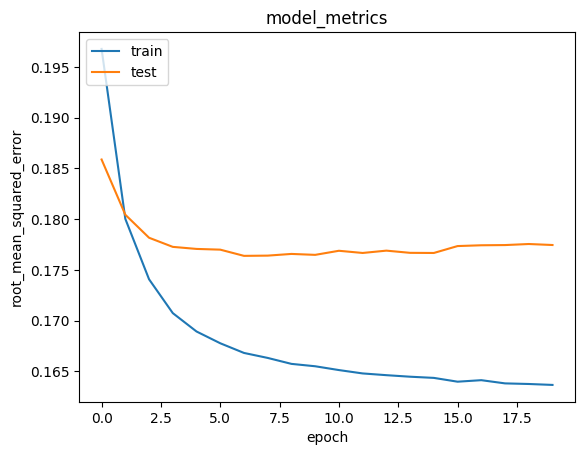

In [63]:
import matplotlib.pyplot as plt
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
movie_df = movies
 
# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movie_visited_by_user = df[df.userId == user_id]
 
# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html 
movie_not_watched = movie_df[~movie_df['movieId'].isin(movie_visited_by_user.movieId.values)]['movieId'] 
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)
 
movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

In [65]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Mendapatkan rekomendasi film

In [66]:
ratings = model.predict(user_movie_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_visited[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('movie with high ratings from user')
print('----' * 8)
 
top_movie_user = (
    movie_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)
 
movie_df_rows = movie_df[movie_df['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres)
 
print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)
 
recommended_movie = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)


551/551 [==============================] - 1s 2ms/step
Showing recommendations for users: 67443
movie with high ratings from user
--------------------------------
Second Best (1994) : Drama
Pelle the Conqueror (Pelle erobreren) (1987) : Drama
Thief, The (Vor) (1997) : Drama
Chorus, The (Choristes, Les) (2004) : Drama
Zeitgeist: The Movie (2007) : Documentary|War
--------------------------------
Top 10 movie recommendation
--------------------------------
Bonheur, Le (1965) : Drama
Sansho the Bailiff (Sanshô dayû) (1954) : Drama
Human Condition I, The (Ningen no joken I) (1959) : Drama|War
Human Condition III, The (Ningen no joken III) (1961) : Drama|War
Four Shades of Brown (Fyra nyanser av brunt) (2004) : Comedy|Drama
Wind, The (1928) : Drama|Western
Love Streams (1984) : Comedy|Drama
Civil War, The (1990) : Documentary|War
Queen: Days of Our Lives (2011) : Documentary
Death on the Staircase (Soupçons) (2004) : Crime|Documentary
